In [4]:
import torch
import torch.nn as nn
import pandas
import matplotlib.pyplot as plt
import random
import numpy

In [5]:
# function returning 1010 pattern
def generate_real():
  real_data = torch.FloatTensor([random.uniform(0.8, 1.0),      # 임의성 추가해 실제 상황과 가깝게 하기 *random.uniform(a, b) == a와 b 사이의 임의의 값 나오게 함
                                 random.uniform(0.0, 0.2),
                                 random.uniform(0.8, 1.0),
                                 random.uniform(0.0, 0.2)])
  return real_data
  
generate_real()

tensor([0.9609, 0.1036, 0.9455, 0.0946])

In [6]:
# 판별기 만들기
class Discriminator(nn.Module):
  def __init__(self):
    # initialize pytorch class
    super().__init__()
    # definitiona of NN layer
    self.model = nn.Sequential(
        nn.Linear(4, 3),
        nn.Sigmoid(),
        nn.Linear(3, 1),
        nn.Sigmoid()
    )

    # loss function
    self.loss_function = nn.MSELoss()

    # Optimiser
    self.optimiser = torch.optim.SGD(self.parameters(), lr = 0.01)

    # initialize variable for counting process
    self.counter = 0;
    self.progress = []

    pass

  def forward(self, inputs):
    # run model
    return self.model(inputs)
  
  def train(self, inputs, targets):
    # calculate NN outputs
    outputs = self.forward(inputs)

    # calculate loss
    loss = self.loss_function(outputs, targets)

    # increase counter and calculate error
    self.counter += 1;
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    if (self.counter % 10000 == 0):
      print("counter = ", self.counter)
      pass
    
    # initialize gradient and update w after back
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()
  
  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0, 1.0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
    pass

In [7]:
# return noise pattern
def generate_random(size):
  random_data = torch.rand(size)    # size == 4 -> 0과 1사이의 값을 가지는 텐서 4개를 반환함
  return random_data

In [8]:
# train for discriminator
D = Discriminator()

for i in range(10000):
  # real data
  D.train(generate_real(), torch.FloatTensor([1.0]))
  # generated data
  D.train(generate_random(4), torch.FloatTensor([0.0]))
  pass

counter =  10000
counter =  20000


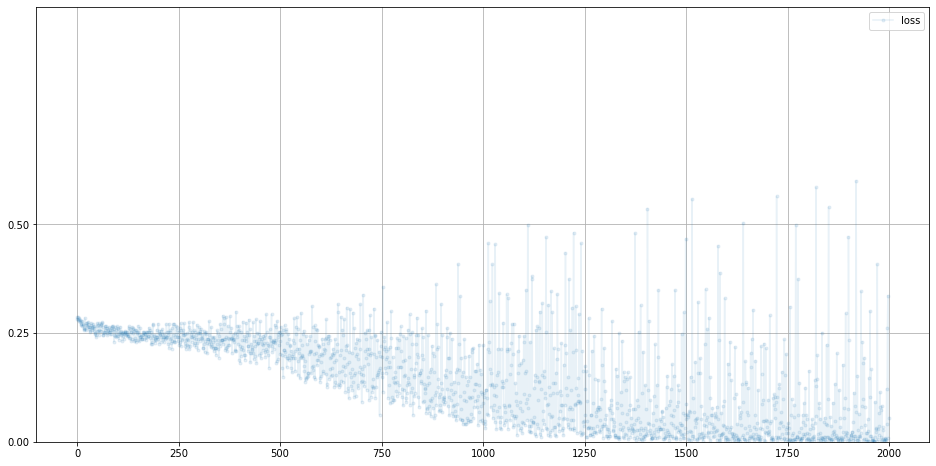

In [9]:
D.plot_progress()

In [10]:
# manually run discriminator to check it can tell real data from fake
print(D.forward(generate_real()).item())
print(D.forward(generate_random(4)).item())

0.7941287755966187
0.0759313553571701


In [11]:
# 판별기 만들기
class Generator(nn.Module):
  def __init__(self):
    # initialize pytorch class
    super().__init__()
    # definitiona of NN layer
    self.model = nn.Sequential(
        nn.Linear(1, 3),
        nn.Sigmoid(),
        nn.Linear(3, 4),
        nn.Sigmoid()
    )

    # Optimiser
    self.optimiser = torch.optim.SGD(self.parameters(), lr = 0.01)

    # initialize variable for counting process
    self.counter = 0;
    self.progress = []

    pass

  def forward(self, inputs):
    # run model
    return self.model(inputs)

  def train(self, D, inputs, targets):
    # calculate NN outputs
    g_output = self.forward(inputs)
    
    # give outputs to discriminator
    d_output = D.forward(g_output)

    # calculate loss
    loss = D.loss_function(d_output, targets)

    # increase counter and store loss every 10 times
    self.counter += 1;
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    
    # initialize gradient and update w after backward
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()
    pass
  
  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0, 1.0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
    pass

In [12]:
G = Generator()
G.forward(torch.FloatTensor([0.5]))

tensor([0.4121, 0.6711, 0.3725, 0.5613], grad_fn=<SigmoidBackward>)

counter =  30000
counter =  40000


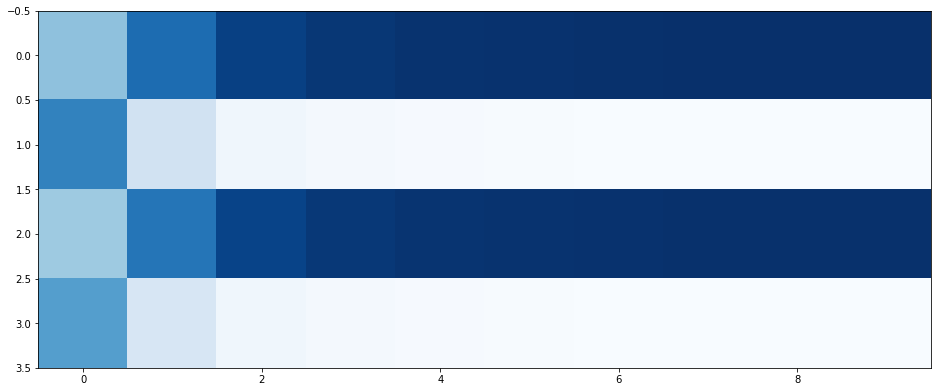

In [13]:
image_list = []

for i in range(10000):
  if (i % 1000 == 0):
    image_list.append(G.forward(torch.FloatTensor([0.5])).detach().numpy())

  # step 1: train discriminator in case of true
  D.train(generate_real(), torch.FloatTensor([1.0]))

  # step 2: train discriminator in case of false
  D.train(G.forward(torch.FloatTensor([0.5])).detach(), torch.FloatTensor([0.0]))
  # step 3: train generator
  G.train(D, torch.FloatTensor([0.5]), torch.FloatTensor([1.0]))

  pass

# plot images collected during training
plt.figure(figsize = (16, 8))
plt.imshow(numpy.array(image_list).T, interpolation='none', cmap='Blues')

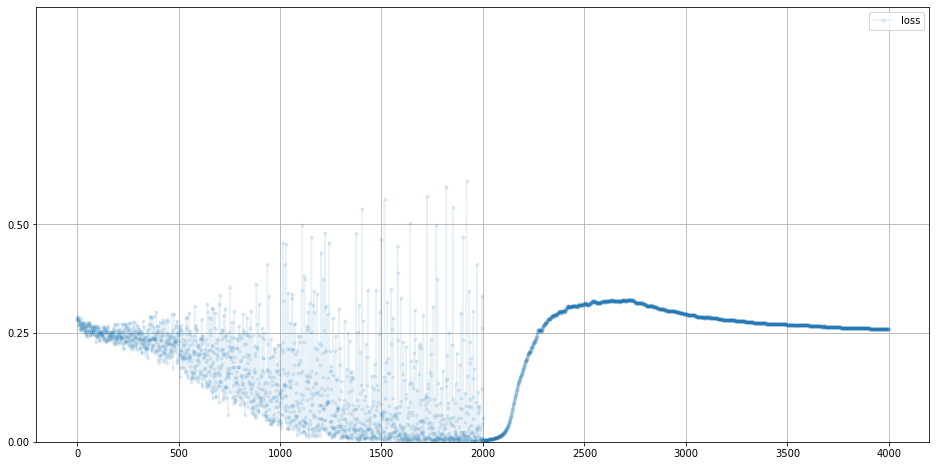

In [14]:
D.plot_progress()

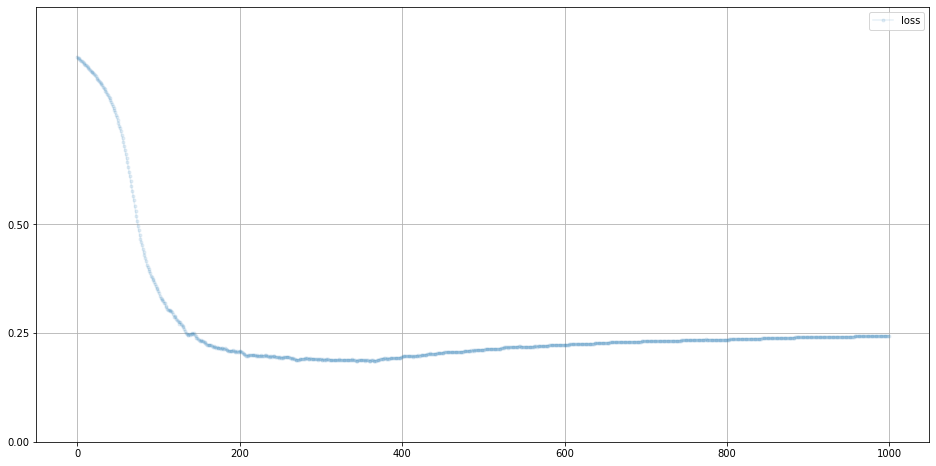

In [15]:
G.plot_progress()

In [16]:
# manually run generator to see it's outputs
G.forward(torch.FloatTensor([0.5]))

tensor([0.9792, 0.0123, 0.9751, 0.0123], grad_fn=<SigmoidBackward>)